# Import required libraries

In [912]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.metrics import *
from math import sqrt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore') # to supress warning

# Load dataset(Location,rice production, Soil parameters, weather parameters)

In [913]:
data=pd.read_csv("Rice_officil_dataset.csv")
data.head()

,Year,Season,Sector_ID,Sector_Name,production,crop_area,yield,Ph,EC,Hp,...,Zn,Na,Fe,Al,ECEC,ESP,intercolumn,RainFall,Max_Temp,Min_Temp
0,2017,A,1106,Muhima,8126.417398,4.514676,2301.324472,7.910000,113.00,0.000000,...,7.8200,39.200000,122.000000,847.0,12.200000,1.400000,1101-A-2017,475,26.968220,15.675612
1,2017,A,1201,Bumbogo,90.436088,0.050242,3980.711758,5.355000,65.50,0.525000,...,1.0350,48.600000,150.500000,850.0,4.055000,6.305000,1102-A-2017,564,26.305527,15.266905
2,2017,A,1212,Nduba,382540.539600,212.522522,4103.230998,5.780000,43.00,0.000000,...,1.5300,25.500000,194.000000,611.0,4.270000,2.600000,1103-A-2017,441,26.672825,15.815752
3,2017,A,1213,Remera,287899.928300,159.944405,3898.417766,0.000000,0.00,0.000000,...,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,1104-A-2017,475,26.968220,15.675612
4,2017,A,2104,Kibirizi,322616.155900,179.231198,3795.145758,5.136667,45.75,0.716667,...,3.0025,29.608333,236.416667,215.0,4.710833,2.973333,1105-A-2017,361,27.187023,16.396612


Load additional soil dataset

In [914]:
data2=pd.read_csv("Soil_texture.csv")
data2.head()

,Sector_id,DISTR,SECT_NAME,SOIL_DEPTH,SOIL_TEXTU
0,4101,RULINDO,Base,<0.5m,>35% Clay
1,3401,NYABIHU,Bigogwe,0.5 - 1.0m,20 - 35% clay
2,3201,RUTSIRO,Boneza,0.5 - 1.0m,>35% Clay
3,3601,RUSIZI,Bugarama,>1.0m,>35% Clay
4,3301,RUBAVU,Bugeshi,0.5 - 1.0m,20 - 35% clay


Enrich Original dataset with soil parameters

In [915]:
dsa={}
for id,dat in zip(data2['Sector_id'].values,data2['SOIL_DEPTH'].values):
    dsa[id]=dat
    

In [916]:
data['SOIL_DEPTH']=data['Sector_ID'].apply(lambda x:dsa[x])

In [917]:
dsa={}
for id,dat in zip(data2['Sector_id'].values,data2['SOIL_TEXTU'].values):
    dsa[id]=dat

In [918]:
data['SOIL_TEXTU']=data['Sector_ID'].apply(lambda x:dsa[x])

# Data Preprocessing

In [919]:
from sklearn.preprocessing import OneHotEncoder

In [920]:
#Produce dummy variables from 'SOIL_DEPTH' field

In [921]:
categories_reshaped = np.array(data['SOIL_DEPTH']).reshape(-1, 1)

In [922]:
encoder = OneHotEncoder()

In [923]:
one_hot_encoded = encoder.fit_transform(categories_reshaped).toarray()

In [924]:
data['SOIL_DEPTH'].unique()

array(['<0.5m', '>1.0m', '0.5 - 1.0m'], dtype=object)

In [925]:
df_new=pd.DataFrame(one_hot_encoded,columns=['Soil_depth<0.5m','Soil_depth>1m','Soil_depth:0.5-1m'])

In [926]:
len(data)

752

In [927]:
df=data.copy()

In [928]:
data['Soil_depth<0.5m']=df_new['Soil_depth<0.5m'].values
data['Soil_depth>1m']=df_new['Soil_depth>1m'].values
data['Soil_depth:0.5-1m']=df_new['Soil_depth:0.5-1m'].values

In [929]:
#Convert 'SOIL_TEXTU' field into binary variables

In [930]:
d={'20 - 35% clay':1,'>35% Clay':0}

In [931]:
data['SOIL_TEXTU']=data['SOIL_TEXTU'].apply(lambda x:d[x])

Conver season into binary varable

In [932]:
data['SeasonN2']=data['Year'].astype(str)+"-"+data['Season']

In [933]:
data['Season'].unique()

array(['A', 'B'], dtype=object)

In [934]:
d={'B':1,'A':0}
data['Season2']=data['Season'].apply(lambda x:d[x])
data.head()

,Year,Season,Sector_ID,Sector_Name,production,crop_area,yield,Ph,EC,Hp,...,RainFall,Max_Temp,Min_Temp,SOIL_DEPTH,SOIL_TEXTU,Soil_depth<0.5m,Soil_depth>1m,Soil_depth:0.5-1m,SeasonN2,Season2
0,2017,A,1106,Muhima,8126.417398,4.514676,2301.324472,7.910000,113.00,0.000000,...,475,26.968220,15.675612,<0.5m,0,0.0,1.0,0.0,2017-A,0
1,2017,A,1201,Bumbogo,90.436088,0.050242,3980.711758,5.355000,65.50,0.525000,...,564,26.305527,15.266905,>1.0m,0,0.0,0.0,1.0,2017-A,0
2,2017,A,1212,Nduba,382540.539600,212.522522,4103.230998,5.780000,43.00,0.000000,...,441,26.672825,15.815752,>1.0m,0,0.0,0.0,1.0,2017-A,0
3,2017,A,1213,Remera,287899.928300,159.944405,3898.417766,0.000000,0.00,0.000000,...,475,26.968220,15.675612,>1.0m,0,0.0,0.0,1.0,2017-A,0
4,2017,A,2104,Kibirizi,322616.155900,179.231198,3795.145758,5.136667,45.75,0.716667,...,361,27.187023,16.396612,<0.5m,0,0.0,1.0,0.0,2017-A,0


Plotting Yield production using agriculture season

In [935]:
import matplotlib.pyplot as plt

In [936]:
df = data.sort_values(by='SeasonN2')

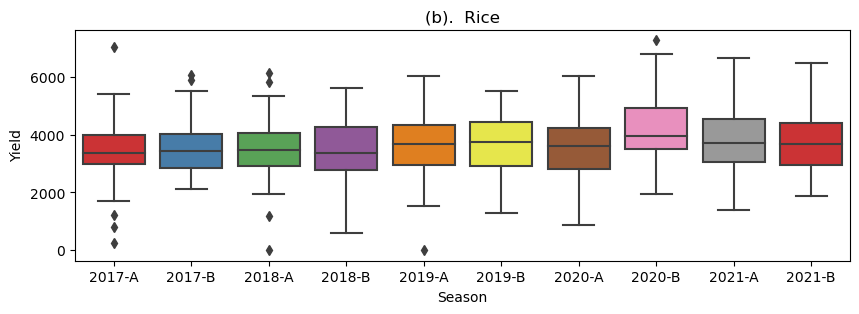

In [937]:
# Plot the boxplot with colors
plt.figure(figsize=(10, 3))
sns.boxplot(x='SeasonN2',y='yield', data=data, palette="Set1")
plt.title('(b).  Rice')
plt.xlabel('Season')
plt.ylabel('Yield')
plt.show()

Handling missing values

In [938]:
data.isna().sum()

Year                 0
Season               0
Sector_ID            0
Sector_Name          0
production           0
crop_area            0
yield                0
Ph                   0
EC                   0
Hp                   0
C                    0
N                    0
P                    0
K                    0
Ca                   0
Mg                   0
S                    0
Mn                   0
Cu                   0
B                    0
Zn                   0
Na                   0
Fe                   0
Al                   0
ECEC                 0
ESP                  0
intercolumn          0
RainFall             0
Max_Temp             0
Min_Temp             0
SOIL_DEPTH           0
SOIL_TEXTU           0
Soil_depth<0.5m      0
Soil_depth>1m        0
Soil_depth:0.5-1m    0
SeasonN2             0
Season2              0
dtype: int64

Handling Outliers

In [939]:
from scipy import stats
def remove_outliers_z_score(data, columns, threshold=3):
    z_scores = np.abs(stats.zscore(data[columns]))
    outlier_rows = (z_scores > threshold).any(axis=1)
    df_no_outliers = data[~outlier_rows]
    return df_no_outliers
columns_to_check = ['yield']
df_no_outliers = remove_outliers_z_score(data, columns_to_check)
df=df_no_outliers

Converting Yield production into classes (0: Low Production, 1: High Production)

In [940]:
df['Class'] =data['yield'].apply(lambda x:0 if x < df['yield'].mean() else  1 )

In [941]:
df['Class'].value_counts()

Class
0    383
1    364
Name: count, dtype: int64

# Calculate crop yield using production and crop area

In [942]:
df['yield']=df['production']/df['crop_area']

In [943]:
df['Class'] =df['yield'].apply(lambda x:0 if x < df['yield'].mean() else  1 )

Selecting fields of interest

In [944]:
df2=df[['Ph',
       'EC', 'Hp', 'C', 'N', 'P', 'K', 'Ca', 'Mg', 'S', 'Mn', 'Cu', 'B', 'Zn',
       'Na', 'Fe', 'Al', 'ECEC', 'ESP', 'RainFall', 'Max_Temp', 'Min_Temp','SOIL_TEXTU', 'Soil_depth<0.5m', 'Soil_depth>1m', 'Soil_depth:0.5-1m','Season2', 'Class']]

Splitting the the dataset into features (X) and Target (Y) varaibles

In [945]:
X=df2[['Ph',
       'EC', 'Hp', 'C', 'N', 'P', 'K', 'Ca', 'Mg', 'S', 'Mn', 'Cu', 'B', 'Zn',
       'Na', 'Fe', 'Al', 'ECEC', 'ESP', 'RainFall', 'Max_Temp', 'Min_Temp','SOIL_TEXTU', 'Soil_depth<0.5m', 'Soil_depth>1m', 'Soil_depth:0.5-1m','Season2']]
Y=df2['Class']

Identifying proper names for features

In [946]:
cols=['Hydrogen Potential',
       'Electrical Conductivity', 'Hydraulic Properties', 'Carbon', 'Nitrogen', 'Phosphorus', 'Potassium', 'Calcium', 'Magnesium', 'Sulfur ', 'Manganese', 'Copper', 'Bore', 'Zinc',
       'Sodium', 'Iron', 'Aluminium', 'Effective cation Exchange Capacity', 'Exchangeable Sodium Percentage', 'Precipitations', 'Maximum Temperature', 'Minimum Temperature','Soil Texture', 'Soil Depth<0.5m', 'Soil Depth>1m', 'Soil Depth:0.5-1m','Agricultural Season']

In [947]:
#Displaying dataset size

In [948]:
X.shape

(747, 27)

In [949]:
df2['Class'].value_counts()

Class
0    467
1    280
Name: count, dtype: int64

Renaming features

In [950]:
X.columns=['Ph', 'EC', 'Hp', 'C', 'N', 'P', 'K', 'Ca', 'Mg', 'S', 'Mn', 'Cu', 'B',
       'Zn', 'Na', 'Fe', 'Al', 'ECEC', 'ESP', 'RainFall', 'Max_Temp',
       'Min_Temp', 'SOIL_TEXTU', 'Soil_depth_less_than_0.5m', 'Soil_depth_greater_than_1m',
       'Soil_depth_ between_0.5 and 1m', 'Season2']

# Apply data Standardization techniques

In [951]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler=StandardScaler()

In [952]:
X=scaler.fit_transform(X)

# Splitting dataset into training and testing subsets

In [953]:
from sklearn.model_selection import train_test_split

In [954]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=22) #18,22

In [955]:
from collections import Counter
Counter(Y_test)

Counter({0: 99, 1: 51})

## Start Model training process:

# Model1: Random Forest

In [956]:
from sklearn.ensemble import RandomForestClassifier # importing algorithm
model=RandomForestClassifier(max_depth=5,random_state=13) # 19 build the model
model.fit(X_train,Y_train) # model training

RandomForestClassifier(max_depth=5, random_state=13)

In [957]:
print('Accuracy = {:.2f}'.format(model.score(X_train,Y_train)))

Accuracy = 0.92


In [958]:
print('Accuracy = {:.2f}'.format(model.score(X_test,Y_test)))

Accuracy = 0.91


In [959]:
from sklearn.metrics import *

In [960]:
# Evaluate model
y_pred1 = (model.predict(X_test) > 0.5).astype("int32")
accuracy2 = accuracy_score(Y_test, y_pred1)
precision2 = precision_score(Y_test, y_pred1)
recall2 = recall_score(Y_test, y_pred1)

print(f'Precision: {precision2} ,Sensitivity : {recall2} ')

Precision: 0.8490566037735849 ,Sensitivity : 0.8823529411764706 


In [961]:
# Evaluate model on training dataset
y_pred = (model.predict(X_train) > 0.5).astype("int32")
accuracy2 = accuracy_score(Y_train, y_pred)
precision2 = precision_score(Y_train, y_pred)
recall2 = recall_score(Y_train, y_pred)

print(f'Precision: {precision2} ,Sensitivity : {recall2} ')

Precision: 0.885593220338983 ,Sensitivity : 0.9126637554585153 


# Model2: eXtreme Gradient Boosting

In [962]:
import xgboost as xgb # importing algorithm
model = xgb.XGBClassifier(max_depth=2,learning_rate=0.1) # build the model4
model.fit(X_train,Y_train) # model training

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [963]:
print('Accuracy = {:.2f}'.format(model.score(X_train,Y_train)))
print('Accuracy = {:.2f}'.format(model.score(X_test,Y_test)))

Accuracy = 0.91
Accuracy = 0.91


Plot features importance in prediction results

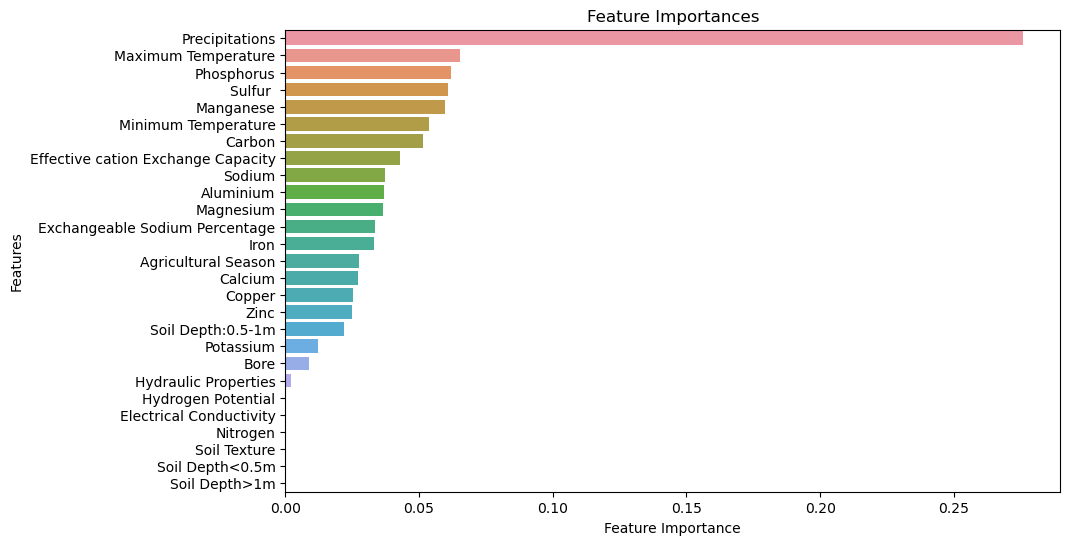

In [964]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `model` is already trained and `X` is your feature matrix

# Get feature importances
importances = model.feature_importances_

# Get feature names if available (otherwise, use feature indices)
feature_names = [t for t in cols]

# Combine feature names and importances into a list of tuples and sort by importance
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Unzip the feature importances into names and values
feature_names, importances = zip(*feature_importances)

# Convert to a pandas DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df)

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

In [965]:
# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9133333333333333
Precision: 0.8275862068965517
Recall: 0.9411764705882353
F1 Score: 0.8807339449541284


# Model 3: Gradient Boosting

In [966]:
from sklearn.ensemble import GradientBoostingClassifier
model3=GradientBoostingClassifier(max_depth=2,random_state=34)
model3.fit(X_train,Y_train)

GradientBoostingClassifier(max_depth=2, random_state=34)

In [967]:
y_pred3 = (model3.predict(X_test) > 0.5).astype("int32")
accuracy2 = accuracy_score(Y_test, y_pred3)
precision2 = precision_score(Y_test, y_pred3)
recall2 = recall_score(Y_test, y_pred3)

print(f'Precision: {precision2} ,Sensitivity : {recall2} ')

Precision: 0.8245614035087719 ,Sensitivity : 0.9215686274509803 


In [968]:
# Evaluate model
y_pred = (model3.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9066666666666666
Precision: 0.8245614035087719
Recall: 0.9215686274509803
F1 Score: 0.8703703703703703


# Model 4: Support Vector machine

In [969]:
model=SVC(kernel='rbf',max_iter=950) # build the model
model.fit(X_train,Y_train) # model training

SVC(max_iter=950)

In [970]:
print("Train-accuracy = ",100*model.score(X_train,Y_train))
print("Testing-accuracy ",100*model.score(X_test,Y_test))

Train-accuracy =  88.107202680067
Testing-accuracy  84.0


In [971]:
y_pred4 = (model.predict(X_test) > 0.5).astype("int32")
accuracy2 = accuracy_score(Y_test, y_pred4)
precision2 = precision_score(Y_test, y_pred4)
recall2 = recall_score(Y_test, y_pred4)

print(f'Precision: {precision2} ,Sensitivity : {recall2} ')
#Precision: 0.7647058823529411 ,Sensitivity : 0.7647058823529411

Precision: 0.7647058823529411 ,Sensitivity : 0.7647058823529411 


Model 5: Artificial Neural Network

In [972]:
from tensorflow import keras

In [973]:
X_train.shape

(597, 27)

In [974]:
import tensorflow as tf
from tensorflow import keras
#Build model architecture of ANN
model = keras.models.Sequential([keras.layers.Dense(units=64,activation='relu',input_shape=[27]),
                                 keras.layers.Dropout(0.4),#0.2
                                 keras.layers.Dense(units=64,activation='relu'),
                                 keras.layers.Dropout(0.4),
                                keras.layers.Dense(units=1,activation='sigmoid')])

In [975]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [976]:
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50,batch_size=32) #120

Epoch 1/50
19/19 [==============================] - 1s 10ms/step - loss: 0.7429 - accuracy: 0.5243 - val_loss: 0.6319 - val_accuracy: 0.6600
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5863 - val_loss: 0.5987 - val_accuracy: 0.7067
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6616 - val_loss: 0.5740 - val_accuracy: 0.7333
Epoch 4/50
19/19 [==============================] - 0s 2ms/step - loss: 0.5967 - accuracy: 0.6767 - val_loss: 0.5452 - val_accuracy: 0.7467
Epoch 5/50
19/19 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.7035 - val_loss: 0.5217 - val_accuracy: 0.7600
Epoch 6/50
19/19 [==============================] - 0s 2ms/step - loss: 0.5479 - accuracy: 0.7136 - val_loss: 0.4981 - val_accuracy: 0.7667
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.5273 - accuracy: 0.7554 - val_loss: 0.4689 - val_accuracy: 0.7800
Epoch 8/50
19/19 [=

In [977]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [978]:
y_pred5 = model.predict(X_test)

5/5 [==============================] - 0s 750us/step


In [979]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [980]:
# Evaluate model
y_pred5 = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(Y_test, y_pred5)
precision = precision_score(Y_test, y_pred5)
recall = recall_score(Y_test, y_pred5)
f1 = f1_score(Y_test, y_pred5)
cm5 = confusion_matrix(Y_test, y_pred5)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

5/5 [==============================] - 0s 877us/step
Accuracy: 0.8733333333333333
Precision: 0.82
Recall: 0.803921568627451
F1 Score: 0.8118811881188118


In [981]:
# Evaluate model on training set
y_pred = (model.predict(X_train) > 0.5).astype("int32")
accuracy = accuracy_score(Y_train, y_pred)
precision = precision_score(Y_train, y_pred)
recall = recall_score(Y_train, y_pred)
f1 = f1_score(Y_train, y_pred)
conf_matrix = confusion_matrix(Y_train, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

19/19 [==============================] - 0s 722us/step
Accuracy: 0.8961474036850922
Precision: 0.8300395256916996
Recall: 0.9170305676855895
F1 Score: 0.871369294605809


# Model 6: Logistic Regression

In [982]:
from sklearn.linear_model import LogisticRegression

In [983]:
model = LogisticRegression(max_iter=700,C=1,random_state=42)
model.fit(X_train,Y_train) # model training
print("Train-accuracy = ",100*model.score(X_train,Y_train))
print("Testing-accuracy ",100*model.score(X_test,Y_test))

Train-accuracy =  86.76716917922947
Testing-accuracy  88.0


In [984]:
y_pred6 = (model.predict(X_test) > 0.5).astype("int32")
accuracy2 = accuracy_score(Y_test, y_pred6)
precision2 = precision_score(Y_test, y_pred6)
recall2 = recall_score(Y_test, y_pred6)

print(f'Precision: {precision2} ,Sensitivity : {recall2} ')
#Precision: 0.7647058823529411 ,Sensitivity : 0.7647058823529411

Precision: 0.8113207547169812 ,Sensitivity : 0.8431372549019608 


# Plotting Confusion matrix

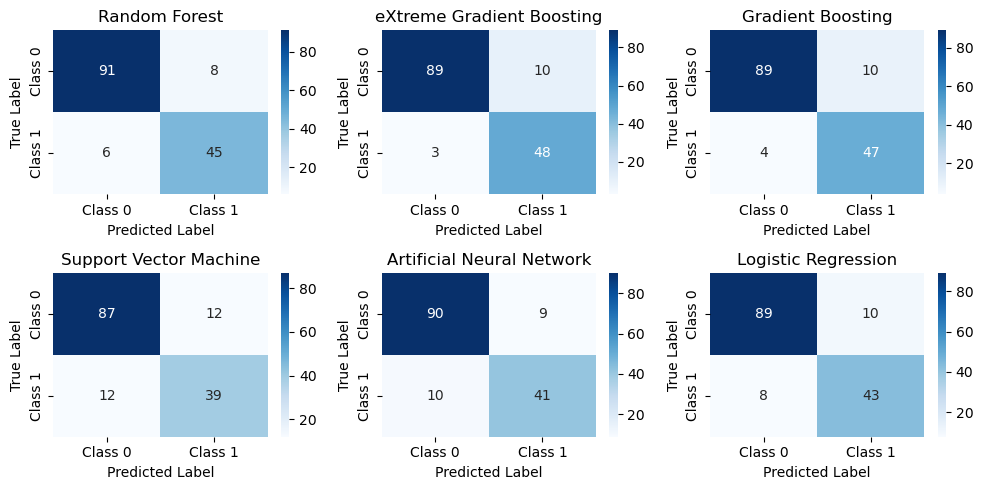

In [985]:
models = {
    "Random Forest": confusion_matrix(Y_test, y_pred1),
    "eXtreme Gradient Boosting": confusion_matrix(Y_test, y_pred2),
    "Gradient Boosting": confusion_matrix(Y_test, y_pred3),
    "Support Vector Machine": confusion_matrix(Y_test, y_pred4),
    "Artificial Neural Network": confusion_matrix(Y_test, y_pred5),
    "Logistic Regression": confusion_matrix(Y_test, y_pred6),
}
# Class labels
labels = ['Class 0', 'Class 1']

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for ax, (model_name, cm) in zip(axes.flat, models.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()